In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM

template = """Question: {question}

Answer: Let's think step by step."""

prompt = ChatPromptTemplate.from_template(template)

model = OllamaLLM(model="llama3")

chain = prompt | model

chain.invoke({"question": "What is LangChain?"})

"A clever introduction! I love it.\n\nAlright, let's break down what LangChain might be:\n\n1. **Lang**: This prefix suggests that LangChain has something to do with language. Perhaps it's a tool or technology related to natural language processing (NLP), linguistics, or computer science.\n2. **Chain**: This word implies connection, continuity, or a series of elements linked together. In the context of language, this might refer to processes, algorithms, or systems that work together to achieve a specific goal.\n\nCombining these insights, I'll take a wild guess:\n\nLangChain could be a type of NLP framework or system that enables the creation of longer, more coherent text sequences by chaining together individual language processing tasks or modules. This might include techniques like language modeling, syntax analysis, semantic reasoning, and context-aware generation.\n\nAm I on the right track?"

In [7]:
import operator
from datetime import datetime
from typing import Annotated, TypedDict, Union

from dotenv import load_dotenv
from langchain import hub
from langchain.agents import create_react_agent
from langchain_community.chat_models import ChatOllama
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode

load_dotenv()

@tool
def get_now(format: str = "%Y-%m-%d %H:%M:%S"):
    """
    Get the current time
    """
    return datetime.now().strftime(format)


tools = [get_now]

tool_executor = ToolNode(tools)


In [8]:
class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]


model = ChatOllama(model="openhermes")
prompt = hub.pull("hwchase17/react")
print("=================", prompt)

agent_runnable = create_react_agent(model, tools, prompt)

c:\Users\rajp2\OneDrive\Desktop\Learning\MultiAgent\env\Lib\site-packages\langsmith\client.py:280: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================= input_variables=['agent_scratchpad', 'input', 'tool_names', 'tools'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'} template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}'


In [12]:
def execute_tools(state):
    print("Called `execute_tools`")
    messages = [state["agent_outcome"]]
    last_message = messages[-1]

    tool_name = last_message.tool

    print(f"Calling tool: {tool_name}")

    action = ToolNode(
        name=tool_name,
        messages_key=last_message.tool_input,
    )
    response = tool_executor.invoke(action)
    return {"intermediate_steps": [(state["agent_outcome"], response)]}


def run_agent(state):
    """
    #if you want to better manages intermediate steps
    inputs = state.copy()
    if len(inputs['intermediate_steps']) > 5:
        inputs['intermediate_steps'] = inputs['intermediate_steps'][-5:]
    """
    agent_outcome = agent_runnable.invoke(state)
    return {"agent_outcome": agent_outcome}


def should_continue(state):
    messages = [state["agent_outcome"]]
    last_message = messages[-1]
    if "Action" not in last_message.log:
        return "end"
    else:
        return "continue"


In [13]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)


workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent", should_continue, {"continue": "action", "end": END}
)


workflow.add_edge("action", "agent")
app = workflow.compile()

input_text = "Whats the current time?"


In [14]:
inputs = {"input": input_text, "chat_history": []}
results = []
for s in app.stream(inputs):
    result = list(s.values())[0]
    results.append(result)
    print(result)


{'agent_outcome': AgentAction(tool="Use `get_now` with format '%Y-%m-%d %H:%M:%S'", tool_input='%Y-%m-%d %H:%M:%S (Year-month-day Hour:Minute:Second)', log="To get the current time, we will use the `get_now` tool. This tool allows us to obtain the current time in a specific format.\n\nAction: Use `get_now` with format '%Y-%m-%d %H:%M:%S'\nAction Input: %Y-%m-%d %H:%M:%S (Year-month-day Hour:Minute:Second)")}
Called `execute_tools`
Calling tool: Use `get_now` with format '%Y-%m-%d %H:%M:%S'


TypeError: ToolNode.__init__() missing 1 required positional argument: 'tools'

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatOllama
template = """Question: {question}

Answer: Let's think step by step."""

prompt = ChatPromptTemplate.from_template(template)

model = ChatOllama(model="llama3")

chain = prompt | model

def chatbot(state: State):
    return {"messages": [chain.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

C:\Users\rajp2\AppData\Local\Temp\ipykernel_23644\2441345325.py:9: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  model = ChatOllama(model="llama3")


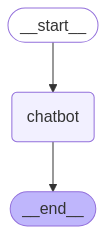

In [3]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [4]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: A HumanMessage!

Let's break it down:

* `content='langchin'`: This is the content of the message, which appears to be a string containing a language code or name.
* `additional_kwargs={}`: This is an empty dictionary that likely contains additional keyword arguments (kwargs) for this message. Since it's empty, there are no specific key-value pairs.
* `response_metadata={}`: Another empty dictionary, this one for response metadata related to the message. No specific information stored here either.
* `id='26611c1a-db93-4161-8453-25fceb7498a2'`: A unique identifier for this HumanMessage instance.

So, in essence, we have a message with some basic information about its content and ID, but no additional metadata or specific data provided.
Assistant: It looks like we have a question in the format of a HumanMessage object, which is used to pass messages between humans and AI models.

Let's break it down:

* `content`: The content of the message is set to `'langchain'`, which sugge

In [25]:
from langchain.tools import tool

# setup the simple tools using LangChain tool decorator
@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


@tool
def square(a: int) -> int:
    """Calculates the square of a number."""
    a = int(a)
    return a * a

# setup the toolkit
toolkit = [add, multiply, square]

In [26]:
from langchain.agents import create_tool_calling_agent

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

#define system prompt for tool calling agent
system_prompt = """ You are a mathematical assistant.
        Use your tools to answer questions. If you do not have a tool to
        answer the question, say so. """

tool_calling_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history", optional=True),
        ("human", "{input}"),
        MessagesPlaceholder("agent_scratchpad"),
    ]
)

tool_runnable = create_tool_calling_agent(model, toolkit, prompt  = tool_calling_prompt)
tool_actions = tool_runnable.invoke({"input": "hi! what's 1+1 and  2 times 2", 'intermediate_steps': []})

NotImplementedError: 

In [ ]:
from langchain.llms import Ollama
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import (
    StreamingStdOutCallbackHandler
)
from langchain.agents import AgentType, initialize_agent
from langchain.tools import StructuredTool

from tools.nslookup_custom_tool import NslookupTool



llm = Ollama(base_url="http://localhost:11434", 
             model="llama2:13b", 
             callback_manager = CallbackManager([StreamingStdOutCallbackHandler()]),
             temperature = 0
             )

nslookup_tool = NslookupTool()
tools = [
    StructuredTool.from_function(
        func=nslookup_tool.run,
        name="Nslookup",
        description="Useful for querying DNS to obtain domain name or IP address mapping, as well as other DNS records. Input: IP address or domain name."
    )
]

agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)


res = agent.run("Do nslookup to google.com, what is google.com ip address?")


In [2]:
# Problem: Model returns JSON-like output with single quotes, which is not valid JSON
# Goal: Ensure model returns output strictly with double quotes for JSON parsing

# Suggestion 1: Enforce JSON schema parsing using pydantic with validation after model output
# Suggestion 2: Use stricter post-processing or LLM configuration to reject malformed output

# Example workaround using Python to sanitize LLM output with single quotes
import json
import ast
from typing import Union

def safe_parse_json(response_text: str) -> Union[dict, None]:
    try:
        # Try parsing directly as JSON
        return json.loads(response_text)
    except json.JSONDecodeError:
        try:
            # Try using ast.literal_eval if single quotes are used
            parsed = ast.literal_eval(response_text)
            # Re-dump to proper JSON string with double quotes
            return json.loads(json.dumps(parsed))
        except Exception as e:
            print("Parsing failed:", e)
            return None

# Example usage
response = """{ 'task_1': "Design course", 'detail_1': 'Outline modules' }"""
parsed = safe_parse_json(response)
print(parsed)

# Additional fix: Append this instruction to every prompt to reduce risk
# "Ensure every string in the JSON output is enclosed in double quotes (\"\"), not single quotes (\'\')."

# Note: LLMs like ChatGPT may still hallucinate formats, so always sanitize before processing.

# If using LangChain or Ollama with JSONOutputParser, you might wrap the parsing call like this:
# try:
#     parsed_output = your_parser.invoke(output)
# except Exception as e:
#     parsed_output = safe_parse_json(output)


{'task_1': 'Design course', 'detail_1': 'Outline modules'}
